# Generacion de datos sinteticos para el modelo

## Fase 1: Configuración y Parámetros del Entorno 🛠️

Esta sección será la "consola de control" de tu simulación. Definiremos todas las variables aquí para que sea fácil experimentar.

    Parámetros Físicos del Robot:

        DISTANCIA_ENTRE_SENSORES: La separación física entre los sensores (ej. 15 cm).

        DISTANCIA_DE_ENFOQUE: Tu distancia de enfoque óptima (150 cm).

    Parámetros de Barrido:

        RANGO_DE_ANGULO: El campo de visión total (140 grados).

        NUMERO_DE_PASOS: Cuántas "fotografías" tomará el sonar para cubrir el rango. Esto definirá el PASO_ANGULAR.

        ANGULOS_DE_BARRIDO: La lista de ángulos discretos que el sensor central usará (ej. [70, 46.6, ...]).

    Parámetros del Sensor:

        SINGLE_BEAM_SHAPE_POINTS: La lista de coordenadas que definen la forma del lóbulo realista que mediste.

    Parámetros de la Simulación:

        NUM_MUESTRAS_POR_PASO: Cuántos objetos aleatorios generar para cada uno de los ángulos de barrido.

        TIPOS_DE_OBJETO: Una lista de geometrías a simular (ej. ['circulo', 'rectangulo']).

        RANGO_DE_TAMAÑO_OBJETO: Los tamaños mínimos y máximos de los objetos.

    Parámetros del Espacio de Salida (para el ML):

        TAMAÑO_DEL_CUADRANTE: El grano de tu rejilla de detección (6 cm).

## Fase 2: Funciones de Modelado Geométrico 📐

Aquí pondremos las funciones reutilizables que se encargan de la geometría, basadas en lo que ya hemos desarrollado.

    obtener_angulos_optimos(theta_central): La función que ya tenemos, que calcula los ángulos de los sensores laterales.

    crear_haz_desde_puntos(...): La función que toma los puntos del lóbulo y crea el polígono shapely base.

    generar_area_de_barrido(angulo_central): Una nueva función clave que:

        Toma el ángulo del sensor central.

        Calcula los ángulos óptimos de los laterales.

        Crea las tres geometrías de los haces (lóbulos).

        Las rota y traslada a sus posiciones correctas.

        Devuelve la unión de los tres haces, que es el área total de detección para ese paso de barrido.

In [76]:
# Importar las librerías necesarias para esta fase
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely import affinity

# ===================================================================
# FASE 1: Configuración y Parámetros del Entorno
# ===================================================================
# En esta sección defines el comportamiento de toda la simulación.

# --- Parámetros Físicos del Robot ---
DISTANCIA_ENTRE_SENSORES = 15  # cm
DISTANCIA_DE_ENFOQUE = 150 # cm (Tu distancia de enfoque óptima)

# --- Parámetros de Barrido ---
RANGO_DE_ANGULO = 140.0  # Grados (Campo de visión total)
NUMERO_DE_PASOS = 9      # Cantidad de "fotografías" del sonar
PASO_ANGULAR = RANGO_DE_ANGULO / (NUMERO_DE_PASOS - 1) # Calculamos el paso para incluir los extremos
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)

# --- Parámetros del Sensor (Lóbulo Realista) ---
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]

# Factor para convertir las unidades de los puntos del lóbulo a cm
FACTOR_ESCALA_HAZ = 100.0


# ===================================================================
# FASE 2: Funciones de Modelado Geométrico
# ===================================================================
# Estas funciones se encargan de toda la geometría del sistema.

def obtener_angulos_optimos(theta_central_deg, d, R):
    """Calcula los ángulos óptimos para los sensores laterales."""
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    
    # Sensor Izquierdo
    angulo_math_izq = np.arctan2(py, px + d)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    
    # Sensor Derecho
    angulo_math_der = np.arctan2(py, px - d)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    """Crea el polígono Shapely base para un solo sensor."""
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def generar_area_de_barrido(angulo_central):
    """
    Genera el área de detección combinada (unión de los 3 haces) para un
    ángulo de barrido específico del sensor central.
    """
    # Obtener los ángulos coordinados
    angulo_izq, angulo_der = obtener_angulos_optimos(
        angulo_central,
        DISTANCIA_ENTRE_SENSORES,
        DISTANCIA_DE_ENFOQUE
    )
    
    # Crear el polígono base del lóbulo
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    
    # --- Orientar y posicionar cada haz ---
    # Haz central: rotado al ángulo de barrido
    haz_central = affinity.rotate(haz_base, angulo_central, origin=(0, 0))
    
    # Haz izquierdo: rotado a su ángulo óptimo y trasladado a su posición
    haz_izq_rotado = affinity.rotate(haz_base, angulo_izq, origin=(0, 0))
    haz_izq = affinity.translate(haz_izq_rotado, xoff=-DISTANCIA_ENTRE_SENSORES)
    
    # Haz derecho: rotado a su ángulo óptimo y trasladado
    haz_der_rotado = affinity.rotate(haz_base, angulo_der, origin=(0, 0))
    haz_der = affinity.translate(haz_der_rotado, xoff=DISTANCIA_ENTRE_SENSORES)
    
    # El área de barrido es la unión de las tres geometrías
    area_total = haz_central.union(haz_izq).union(haz_der)
    
    return area_total

Ángulos de barrido calculados (grados):
[-70.  -52.5 -35.  -17.5   0.   17.5  35.   52.5  70. ]


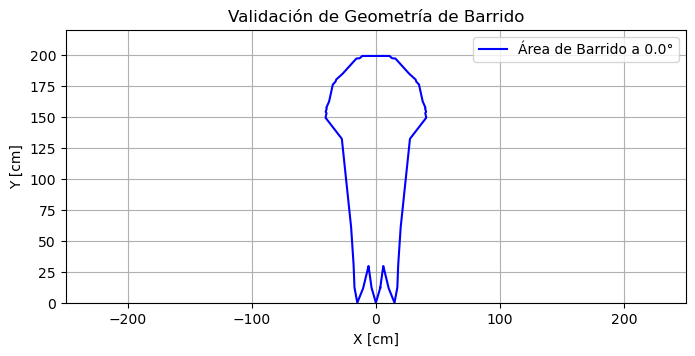

In [77]:
# ===================================================================
# Bloque de Validación y Visualización (para probar en el notebook)
# ===================================================================

print("Ángulos de barrido calculados (grados):")
print(np.round(ANGULOS_DE_BARRIDO, 2))

# Elige un ángulo de la lista para visualizar (ej. el segundo paso: 46.7°)
angulo_de_prueba = ANGULOS_DE_BARRIDO[4] 

# Genera el área de detección para ese ángulo
area_de_prueba = generar_area_de_barrido(angulo_de_prueba)

# Dibuja el resultado
fig, ax = plt.subplots(figsize=(8, 8))
if area_de_prueba.geom_type == 'Polygon':
    ax.plot(*area_de_prueba.exterior.xy, color='blue', label=f'Área de Barrido a {angulo_de_prueba:.1f}°')
elif area_de_prueba.geom_type == 'MultiPolygon':
    for poly in area_de_prueba.geoms:
        ax.plot(*poly.exterior.xy, color='blue')
    ax.scatter([],[], color='blue', label=f'Área de Barrido a {angulo_de_prueba:.1f}°') # Para la leyenda


ax.set_title("Validación de Geometría de Barrido")
ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
ax.set_xlim(-250, 250); ax.set_ylim(0, 220)
ax.set_aspect('equal', adjustable='box'); ax.grid(True)
ax.legend()
plt.show()

## Fase 3: Simulación de la Reflexión del Eco (Ray-Tracing Simplificado) 🌊

Esta es la parte más novedosa. Crearemos una función que imite cómo los sensores recibirían un eco de un objeto simulado.

    simular_reflexiones(objeto, angulo_central):

        Entrada: Un objeto (un polígono shapely) y el angulo_central del barrido.

        Proceso:

            Genera las geometrías de los tres haces para ese ángulo (haz_izq, haz_cen, haz_der).

            Para cada uno de los 3 sensores:

                Comprueba si su haz individual se interseca con el objeto.

                Si hay intersección, significa que ese sensor "ve" el objeto.

                Calcula la distancia desde el origen del sensor hasta el punto más cercano del objeto. Este será nuestro tiempo de vuelo simulado.

                Si no hay intersección, la distancia para ese sensor es infinita (o un valor muy grande).

        Salida: Devuelve una lista con los 3 tiempos de eco simulados.

In [78]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely import affinity
import random

# ===================================================================
# FASE 1: Configuración y Parámetros (sin cambios)
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 8
PASO_ANGULAR = RANGO_DE_ANGULO / (NUMERO_DE_PASOS - 1)
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0

# ===================================================================
# FASE 2: Funciones de Modelado Geométrico (sin cambios)
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad)
    py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d)
    angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d)
    angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

# ===================================================================
# FASE 3: Simulación de la Reflexión del Eco
# ===================================================================
# Esta nueva función simula los tiempos de eco para un objeto dado.

def simular_reflexiones(objeto, angulo_central):
    """
    Simula las distancias de eco de los 3 sensores a un objeto, para un
    ángulo de barrido específico.
    """
    # Orígenes de los sensores
    origen_s1 = Point(-DISTANCIA_ENTRE_SENSORES, 0)
    origen_s2 = Point(0, 0)
    origen_s3 = Point(DISTANCIA_ENTRE_SENSORES, 0)
    
    # Calcular los ángulos óptimos para el barrido
    angulo_izq, angulo_der = obtener_angulos_optimos(
        angulo_central,
        DISTANCIA_ENTRE_SENSORES,
        DISTANCIA_DE_ENFOQUE
    )
    
    # Crear la geometría base del haz
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    
    # Generar las geometrías de los tres haces en sus posiciones y orientaciones
    haz_central = affinity.rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = affinity.translate(affinity.rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = affinity.translate(affinity.rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    
    haces = [haz_izq, haz_central, haz_der]
    origenes = [origen_s1, origen_s2, origen_s3]
    distancias_eco = []
    
    # Para cada sensor, comprobar si "ve" el objeto
    for haz, origen in zip(haces, origenes):
        # La condición es que el objeto se superponga con el haz del sensor
        if objeto.intersects(haz):
            # La distancia del eco es la distancia desde el sensor al punto más cercano del objeto
            distancia = origen.distance(objeto)
            distancias_eco.append(distancia)
        else:
            # Si no hay intersección, el sensor no recibe eco de este objeto.
            # Usamos un valor muy grande para representar "sin eco".
            distancias_eco.append(np.inf)
            
    return distancias_eco, haces # Devolvemos los haces para poder visualizarlos

Resultados para un objeto en (-60.0, 120.0) con barrido a 23.3°:
--------------------------------------------------
Distancia simulada Sensor 1 (izq): 123.16 cm
Distancia simulada Sensor 2 (cen): 129.17 cm
Distancia simulada Sensor 3 (der): 136.51 cm
--------------------------------------------------


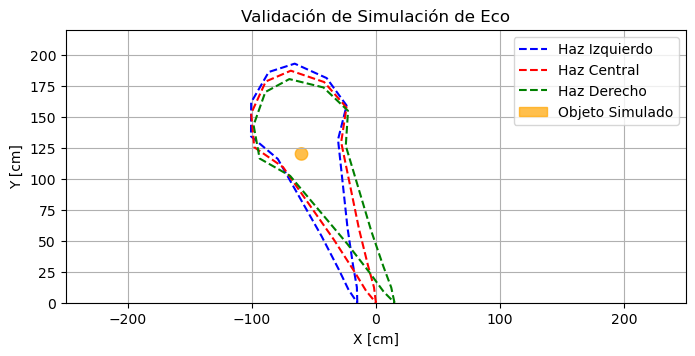

In [79]:
# ===================================================================
# Bloque de Validación y Visualización (para probar la Fase 3)
# ===================================================================

# 1. Elige un ángulo de barrido para la prueba
angulo_de_prueba = 23.3  # Puedes cambiar este valor

# 2. Crea un objeto de prueba (un círculo de 5 cm de radio) en una posición
#    que debería ser visible en ese ángulo de barrido.
objeto_de_prueba = Point(-60, 120).buffer(5)

# 3. Llama a la función de simulación
distancias, haces_de_prueba = simular_reflexiones(objeto_de_prueba, angulo_de_prueba)

print(f"Resultados para un objeto en ({objeto_de_prueba.centroid.x:.1f}, {objeto_de_prueba.centroid.y:.1f}) "
      f"con barrido a {angulo_de_prueba}°:")
print("-" * 50)
print(f"Distancia simulada Sensor 1 (izq): {distancias[0]:.2f} cm")
print(f"Distancia simulada Sensor 2 (cen): {distancias[1]:.2f} cm")
print(f"Distancia simulada Sensor 3 (der): {distancias[2]:.2f} cm")
print("-" * 50)


# 4. Visualiza el resultado para confirmación
fig, ax = plt.subplots(figsize=(8, 8))

# Dibuja los tres haces
colores = ['blue', 'red', 'green']
nombres = ['Haz Izquierdo', 'Haz Central', 'Haz Derecho']
for haz, color, nombre in zip(haces_de_prueba, colores, nombres):
    ax.plot(*haz.exterior.xy, color=color, linestyle='--', label=nombre)

# Dibuja el objeto de prueba
ax.fill(*objeto_de_prueba.exterior.xy, color='orange', alpha=0.7, label='Objeto Simulado')

ax.set_title("Validación de Simulación de Eco")
ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
ax.set_xlim(-250, 250); ax.set_ylim(0, 220)
ax.set_aspect('equal', adjustable='box'); ax.grid(True)
ax.legend()
plt.show()

## Fase 4: Generación del Dataset (Bucle Principal) 🔄

Este es el corazón del script, donde todo se une.

    Inicializar: Crea una rejilla de cuadrantes global que cubra todo el semicírculo de 180 grados y dos listas vacías: features y labels.

    Bucle Externo (por Ángulo): Itera sobre cada angulo_central en tu lista ANGULOS_DE_BARRIDO.

        Calcula el area_de_barrido para ese ángulo.

    Bucle Interno (por Muestra): Itera NUM_MUESTRAS_POR_PASO veces.

        Generar Objeto Aleatorio:

            Elige un tipo y tamaño de objeto al azar.

            Crea el polígono del objeto en una posición aleatoria dentro del area_de_barrido.

        Calcular la Etiqueta (Y): Determina con qué cuadrantes de la rejilla global se superpone el objeto. Esto genera el vector de salida (la "label").

        Calcular las Características (X):

            Llama a simular_reflexiones para obtener los 3 tiempos de eco.

            ¡Crucial! Pasa estos 3 tiempos a una versión simplificada de tu función output_dimention_pulses de helpers.py. Esto convertirá los tiempos de eco en la "firma de eco" de 243 valores, asegurando que tus datos simulados tengan el mismo formato que tus datos reales.

            Concatena el angulo_central con la firma de eco de 243 valores para crear el vector de características final (244 valores).

        Guardar: Añade el vector de características a features y el vector de etiquetas a labels.



In [80]:
# Importar las librerías necesarias para estas fases
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box
from shapely.affinity import rotate, translate
import random
import pandas as pd
from tqdm.notebook import tqdm # Para una barra de progreso visual

# ===================================================================
# FASE 1: Configuración y Parámetros (sin cambios)
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 9
PASO_ANGULAR = RANGO_DE_ANGULO / (NUMERO_DE_PASOS - 1)
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0

# --- Parámetros de la Simulación ---
NUM_MUESTRAS_POR_PASO = 250  # Generaremos 250 objetos por cada ángulo de barrido
TIPOS_DE_OBJETO = ['circulo', 'rectangulo']
RANGO_DE_TAMAÑO_OBJETO = [5.0, 15.0] # en cm (radio para círculos, lado para cuadrados)
TAMAÑO_DEL_CUADRANTE = 6.0 # en cm
VELOCIDAD_SONIDO = 34300 # cm/s
FRECUENCIA_MUESTREO_ADC = 140000 # Hz (simula la captura cruda)
FRECUENCIA_MUESTREO_ML = 6800   # Hz (la frecuencia del espacio de características)


# ===================================================================
# FASE 2 y 3: Funciones Geométricas y de Simulación de Eco (sin cambios)
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad); py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d); angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d); angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)
    
def generar_area_de_barrido(angulo_central):
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    haz_central = rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = translate(rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = translate(rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    return haz_central.union(haz_izq).union(haz_der), [haz_izq, haz_central, haz_der]

def simular_reflexiones(objeto, haces_individuales):
    origenes = [Point(-DISTANCIA_ENTRE_SENSORES, 0), Point(0, 0), Point(DISTANCIA_ENTRE_SENSORES, 0)]
    distancias_eco = []
    for haz, origen in zip(haces_individuales, origenes):
        if objeto.intersects(haz):
            distancia = origen.distance(objeto)
            distancias_eco.append(distancia)
        else:
            distancias_eco.append(np.inf)
    return distancias_eco

# ===================================================================
# FASE 4: Generación del Dataset (Bucle Principal)
# ===================================================================

def distancias_a_firma_eco(distancias_cm):
    """
    Convierte las 3 distancias de eco simuladas a la "firma de eco" de 243 valores
    que espera el modelo de ML.
    """
    firma_eco_total = []
    ratio_conversion = FRECUENCIA_MUESTREO_ML / FRECUENCIA_MUESTREO_ADC
    
    for dist_cm in distancias_cm:
        firma_sensor = np.zeros(81)
        if dist_cm != np.inf:
            # Calcular tiempo de ida y vuelta
            tiempo_eco = (2 * dist_cm) / VELOCIDAD_SONIDO
            # Convertir tiempo a índice de muestra del ADC
            indice_adc = int(tiempo_eco * FRECUENCIA_MUESTREO_ADC)
            # Simular la transformación de `output_dimention_pulses`
            # Esta es una aproximación, asumiendo que el eco se mapea a un índice
            indice_ml = int((indice_adc - 100) * ratio_conversion) # Restamos 100 por el offset
            
            if 0 <= indice_ml < 81:
                firma_sensor[indice_ml] = 1
        firma_eco_total.extend(firma_sensor)
        
    return np.array(firma_eco_total)


def generar_objeto_aleatorio(area_madre):
    """Genera un objeto (círculo o rectángulo) en una posición aleatoria dentro del área dada."""
    min_x, min_y, max_x, max_y = area_madre.bounds
    tipo = random.choice(TIPOS_DE_OBJETO)
    tamaño = random.uniform(*RANGO_DE_TAMAÑO_OBJETO)
    
    # Intenta generar un objeto que esté completamente dentro del área
    for _ in range(50): # Limita los intentos para evitar bucles infinitos
        px = random.uniform(min_x, max_x)
        py = random.uniform(min_y, max_y)
        
        if tipo == 'circulo':
            objeto = Point(px, py).buffer(tamaño)
        else: # rectangulo
            objeto = box(px, py, px + tamaño, py + tamaño)
            
        if area_madre.contains(objeto):
            return objeto
            
    return None # No se pudo generar un objeto válido

# --- Bucle Principal de Generación ---
features_list = []
labels_list = []

# 1. Crear la rejilla de cuadrantes global
area_total_visible = box(-250, 0, 250, 220)
x_coords = np.arange(area_total_visible.bounds[0], area_total_visible.bounds[2], TAMAÑO_DEL_CUADRANTE)
y_coords = np.arange(area_total_visible.bounds[1], area_total_visible.bounds[3], TAMAÑO_DEL_CUADRANTE)
cuadrantes_globales = [box(x, y, x + TAMAÑO_DEL_CUADRANTE, y + TAMAÑO_DEL_CUADRANTE) for x in x_coords for y in y_coords]
num_cuadrantes = len(cuadrantes_globales)


print(f"Generando dataset con {NUMERO_DE_PASOS} pasos angulares...")
# Bucle Externo: Itera sobre cada ángulo de barrido
for angulo_central in tqdm(ANGULOS_DE_BARRIDO, desc="Progreso del Barrido"):
    
    # Genera el área de detección y los haces individuales para este ángulo
    area_de_barrido, haces_individuales = generar_area_de_barrido(angulo_central)
    
    # Bucle Interno: Genera N muestras por cada ángulo
    for _ in range(NUM_MUESTRAS_POR_PASO):
        
        # Genera un objeto aleatorio dentro del área de este barrido
        objeto = generar_objeto_aleatorio(area_de_barrido)
        if objeto is None: continue # Si no se pudo generar, saltar

        # --- Calcular la Etiqueta (Y) ---
        label = np.zeros(num_cuadrantes)
        for i, cuadrante in enumerate(cuadrantes_globales):
            if objeto.intersects(cuadrante):
                label[i] = 1
        
        # --- Calcular las Características (X) ---
        distancias_eco = simular_reflexiones(objeto, haces_individuales)
        firma_eco_ml = distancias_a_firma_eco(distancias_eco)
        
        # Feature final: [angulo, eco_s1..., eco_s2..., eco_s3...]
        feature = np.concatenate(([angulo_central], firma_eco_ml))
        
        # Guardar en las listas
        features_list.append(feature)
        labels_list.append(label)

print("\nGeneración del dataset completada.")
print(f"Total de muestras generadas: {len(features_list)}")

# ===================================================================
# FASE 5: Guardado de Archivos
# ===================================================================

# Convertir a DataFrames y guardar
df_features = pd.DataFrame(features_list)
df_labels = pd.DataFrame(labels_list)

df_features.to_csv("features_simuladas.csv", index=False)
df_labels.to_csv("labels_simuladas.csv", index=False)

print("\nArchivos 'features_simuladas.csv' y 'labels_simuladas.csv' guardados.")

Generando dataset con 9 pasos angulares...


Progreso del Barrido:   0%|          | 0/9 [00:00<?, ?it/s]


Generación del dataset completada.
Total de muestras generadas: 2250

Archivos 'features_simuladas.csv' y 'labels_simuladas.csv' guardados.


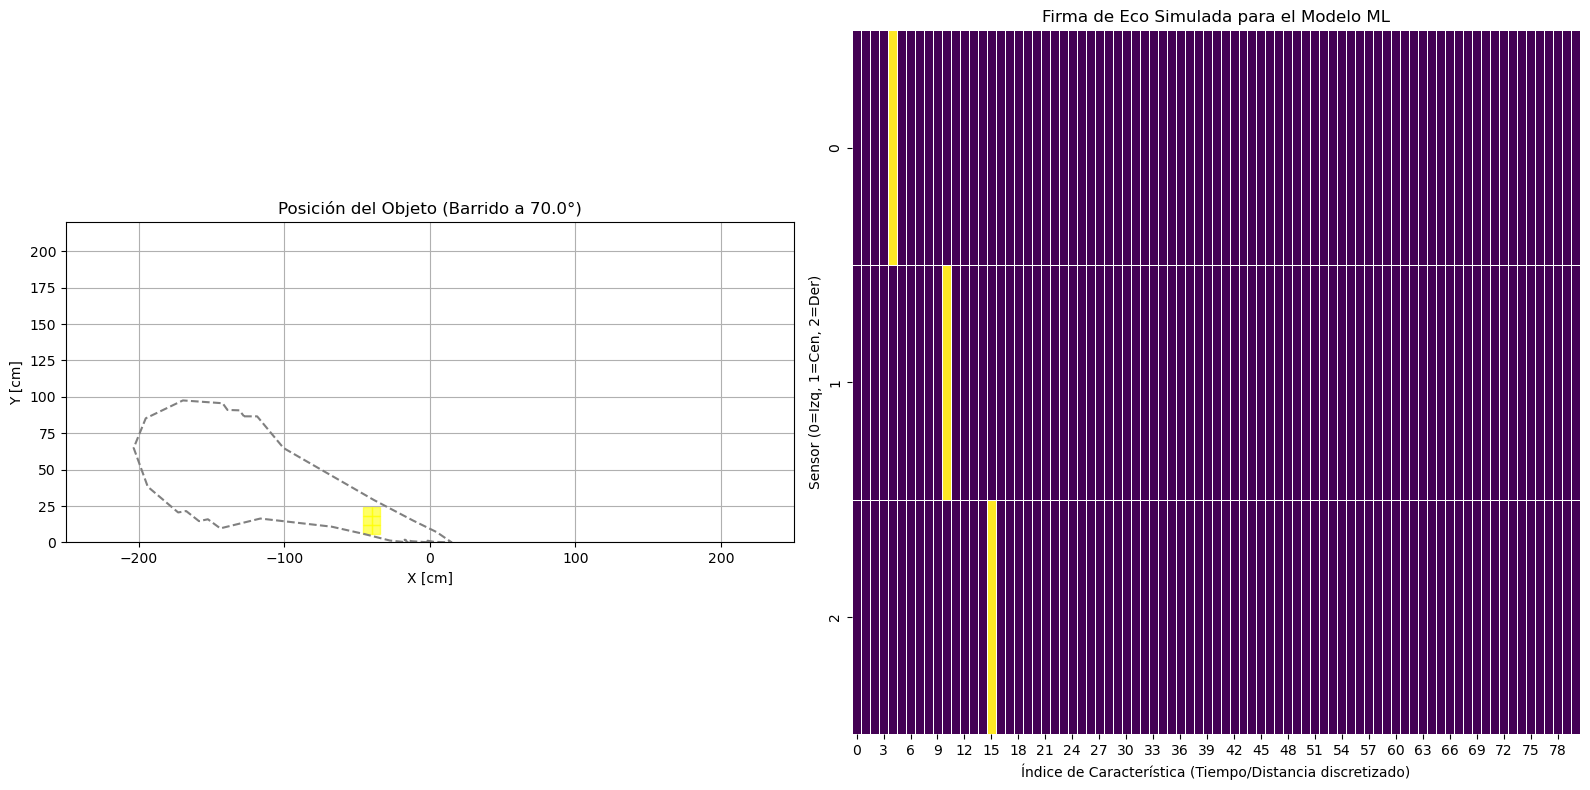

In [83]:
# ===================================================================
# Bloque de Validación y Visualización (para probar una muestra)
# ===================================================================
import seaborn as sns # Necesario para el heatmap
# Tomar la última muestra generada para visualizar
ultima_feature = features_list[-15]
ultima_label = labels_list[-15]

# Extraer la información de la muestra
angulo_muestra = ultima_feature[0]
firma_eco_muestra = ultima_feature[1:] # Los 243 valores del eco
area_muestra, _ = generar_area_de_barrido(angulo_muestra)
cuadrantes_activos_indices = np.where(ultima_label == 1)[0]

# Crear una figura con dos subplots (1 fila, 2 columnas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- Gráfico 1: Vista Espacial (como antes) ---
if area_muestra.geom_type == 'Polygon': ax1.plot(*area_muestra.exterior.xy, color='gray', linestyle='--')
elif area_muestra.geom_type == 'MultiPolygon':
    for poly in area_muestra.geoms: ax1.plot(*poly.exterior.xy, color='gray', linestyle='--')

for idx in cuadrantes_activos_indices:
    cuadrante = cuadrantes_globales[idx]
    ax1.fill(*cuadrante.exterior.xy, color='yellow', alpha=0.6)

ax1.set_title(f"Posición del Objeto (Barrido a {angulo_muestra:.1f}°)")
ax1.set_xlabel("X [cm]"); ax1.set_ylabel("Y [cm]")
ax1.set_xlim(-250, 250); ax1.set_ylim(0, 220)
ax1.set_aspect('equal', adjustable='box'); ax1.grid(True)

# --- Gráfico 2: Firma de Eco Simulada ---
# Reorganizar el vector de 243 a una matriz de 3x81
firma_eco_matriz = firma_eco_muestra.reshape(3, 81)

sns.heatmap(firma_eco_matriz, ax=ax2, cbar=False, cmap="viridis", linewidths=.5)
ax2.set_title("Firma de Eco Simulada para el Modelo ML")
ax2.set_xlabel("Índice de Característica (Tiempo/Distancia discretizado)")
ax2.set_ylabel("Sensor (0=Izq, 1=Cen, 2=Der)")

plt.tight_layout() # Ajusta el espaciado entre gráficos
plt.show()

### Dataset multiobjeto y raytracing con oclusion

En esta seccion mejoraremos la simulacion, agregando multiples objetos al sistema convirtiendo el problema de clasificacion a multi etiqueta. ademas incluiremos el concepto de oclusion, por lo que la simulacion tendra en cuenta la sombra que generan los objetos mas cercanos respecto a los lejanos.

#### Fase 3: Generación de Escenas Complejas.

El objetivo aquí es crear una función que, en lugar de generar un solo objeto, construya una "escena" completa y aleatoria en cada iteración. Esta escena contendrá un número variable de objetos de diferentes tipos (círculos, rectángulos y "paredes") y tamaños, distribuidos de forma aleatoria dentro del campo de visión total del sonar.

In [84]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box, LineString
from shapely.affinity import rotate, translate
import random

# ===================================================================
# FASE 1: Configuración y Parámetros (Expandida)
# ===================================================================
# --- Parámetros Físicos y de Barrido (sin cambios) ---
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 8
PASO_ANGULAR = RANGO_DE_ANGULO / (NUMERO_DE_PASOS - 1)
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0

# --- Parámetros de la Escena (NUEVO) ---
MAX_OBJETOS_POR_ESCENA = 10
# Probabilidades para cada tipo de objeto
PROPORCIONES_OBJETOS = {
    'circulo': 0,
    'rectangulo': 1,
    'pared': 0
}
# Rango de tamaños [min, max] en cm
RANGO_TAMAÑO_CIRCULO = [5.0, 12.0]  # Radios
RANGO_TAMAÑO_RECTANGULO = [8.0, 20.0] # Lados de cuadrados
RANGO_TAMAÑO_PARED = [50.0, 100.0] # Longitud de la pared

# ===================================================================
# FASE 2: Funciones de Modelado Geométrico (sin cambios)
# ===================================================================
# ... (Aquí irían las funciones obtener_angulos_optimos, crear_haz_desde_puntos,
#      y generar_area_de_barrido que ya tenemos, las omito por brevedad pero
#      deben estar en el notebook para que esta celda funcione)
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad); py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d); angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d); angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def generar_area_de_barrido(angulo_central):
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    haz_central = rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = translate(rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = translate(rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    return haz_central.union(haz_izq).union(haz_der)
# ===================================================================
# FASE 3: Generación de Escenas Complejas
# ===================================================================

def generar_escena_aleatoria(area_total_visible):
    """
    Genera una escena con un número aleatorio de objetos de diferentes tipos y tamaños
    dentro del área de visión total del sonar.
    """
    escena = []
    num_objetos = random.randint(1, MAX_OBJETOS_POR_ESCENA)
    min_x, min_y, max_x, max_y = area_total_visible.bounds
    
    tipos = list(PROPORCIONES_OBJETOS.keys())
    probabilidades = list(PROPORCIONES_OBJETOS.values())

    for _ in range(num_objetos):
        # Elige un tipo de objeto basado en las probabilidades
        tipo_objeto = np.random.choice(tipos, p=probabilidades)
        
        # Posición aleatoria
        px = random.uniform(min_x, max_x)
        py = random.uniform(min_y, max_y)
        
        objeto = None
        if tipo_objeto == 'circulo':
            radio = random.uniform(*RANGO_TAMAÑO_CIRCULO)
            objeto = Point(px, py).buffer(radio)
        
        elif tipo_objeto == 'rectangulo':
            lado = random.uniform(*RANGO_TAMAÑO_RECTANGULO)
            # Generamos un cuadrado
            objeto = box(px - lado/2, py - lado/2, px + lado/2, py + lado/2)
            # Rotación aleatoria para más variedad
            objeto = rotate(objeto, random.uniform(0, 360), origin='centroid')

        elif tipo_objeto == 'pared':
            longitud = random.uniform(*RANGO_TAMAÑO_PARED)
            # Generar como una línea gruesa (un rectángulo delgado)
            p1 = (px - longitud/2, py)
            p2 = (px + longitud/2, py)
            objeto = LineString([p1, p2]).buffer(2) # 2 cm de grosor
            # Rotación aleatoria
            objeto = rotate(objeto, random.uniform(0, 360), origin='centroid')

        # Comprobación de colisiones simples: si el nuevo objeto no se superpone
        # demasiado con los existentes, lo añadimos.
        colision = False
        if objeto:
            for obj_existente in escena:
                # Si el nuevo objeto está casi completamente dentro de uno existente, no lo añadimos.
                if obj_existente.contains(objeto.centroid):
                    colision = True
                    break
            if not colision:
                escena.append(objeto)
                
    return escena

Escena generada con 8 objetos.


/tmp/ipykernel_7874/1872588405.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap('Set2', MAX_OBJETOS_POR_ESCENA)


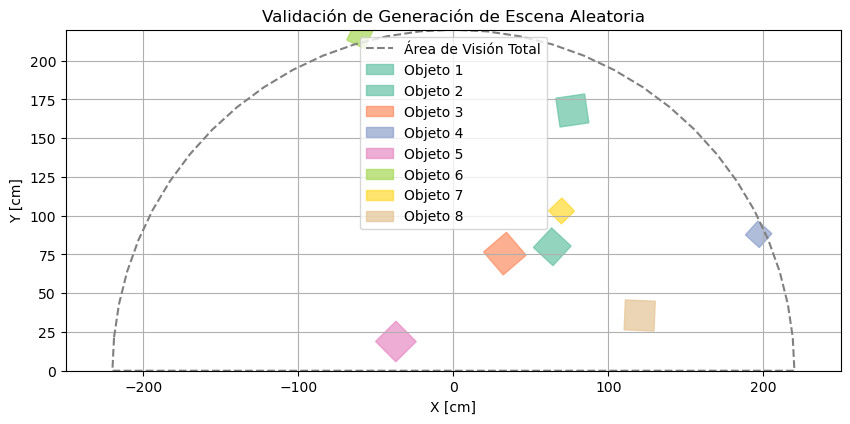

In [85]:
# ===================================================================
# Bloque de Validación y Visualización (para probar la Fase 3)
# ===================================================================

# 1. Definir el área total visible para generar los objetos
# Un semicírculo grande es una buena aproximación del área total de 180°
area_total_simulacion = Point(0, 0).buffer(220).intersection(box(-250, 0, 250, 220))

# 2. Generar una escena aleatoria de prueba
escena_de_prueba = generar_escena_aleatoria(area_total_simulacion)

print(f"Escena generada con {len(escena_de_prueba)} objetos.")

# 3. Visualizar la escena generada
fig, ax = plt.subplots(figsize=(10, 8))

# Dibujar el área total de simulación
ax.plot(*area_total_simulacion.exterior.xy, color='gray', linestyle='--', label='Área de Visión Total')

# Dibujar cada objeto en la escena
colores = plt.cm.get_cmap('Set2', MAX_OBJETOS_POR_ESCENA)
for i, objeto in enumerate(escena_de_prueba):
    if objeto.geom_type == 'Polygon':
        ax.fill(*objeto.exterior.xy, color=colores(i), alpha=0.7, label=f'Objeto {i+1}')
    elif objeto.geom_type == 'MultiPolygon': # A veces un buffer puede crear esto
        for poly in objeto.geoms:
            ax.fill(*poly.exterior.xy, color=colores(i), alpha=0.7)
        ax.scatter([], [], color=colores(i), label=f'Objeto {i+1}') # Para la leyenda

# Configuración del gráfico
ax.set_title("Validación de Generación de Escena Aleatoria")
ax.set_xlabel("X [cm]"); ax.set_ylabel("Y [cm]")
ax.set_xlim(-250, 250); ax.set_ylim(0, 220)
ax.set_aspect('equal', adjustable='box'); ax.grid(True)
ax.legend()
plt.show()

#### Fase 4 y 5: Generación del Dataset con Oclusión y Etiquetas Físicas

Este es el paso más complejo y crucial. Aquí implementaremos el "ray-tracing con oclusión", generaremos las etiquetas multi-objeto basadas en la física del eco y construiremos el bucle principal que creará nuestro dataset final.

[1093 1094 1167 1241 1279 1422]


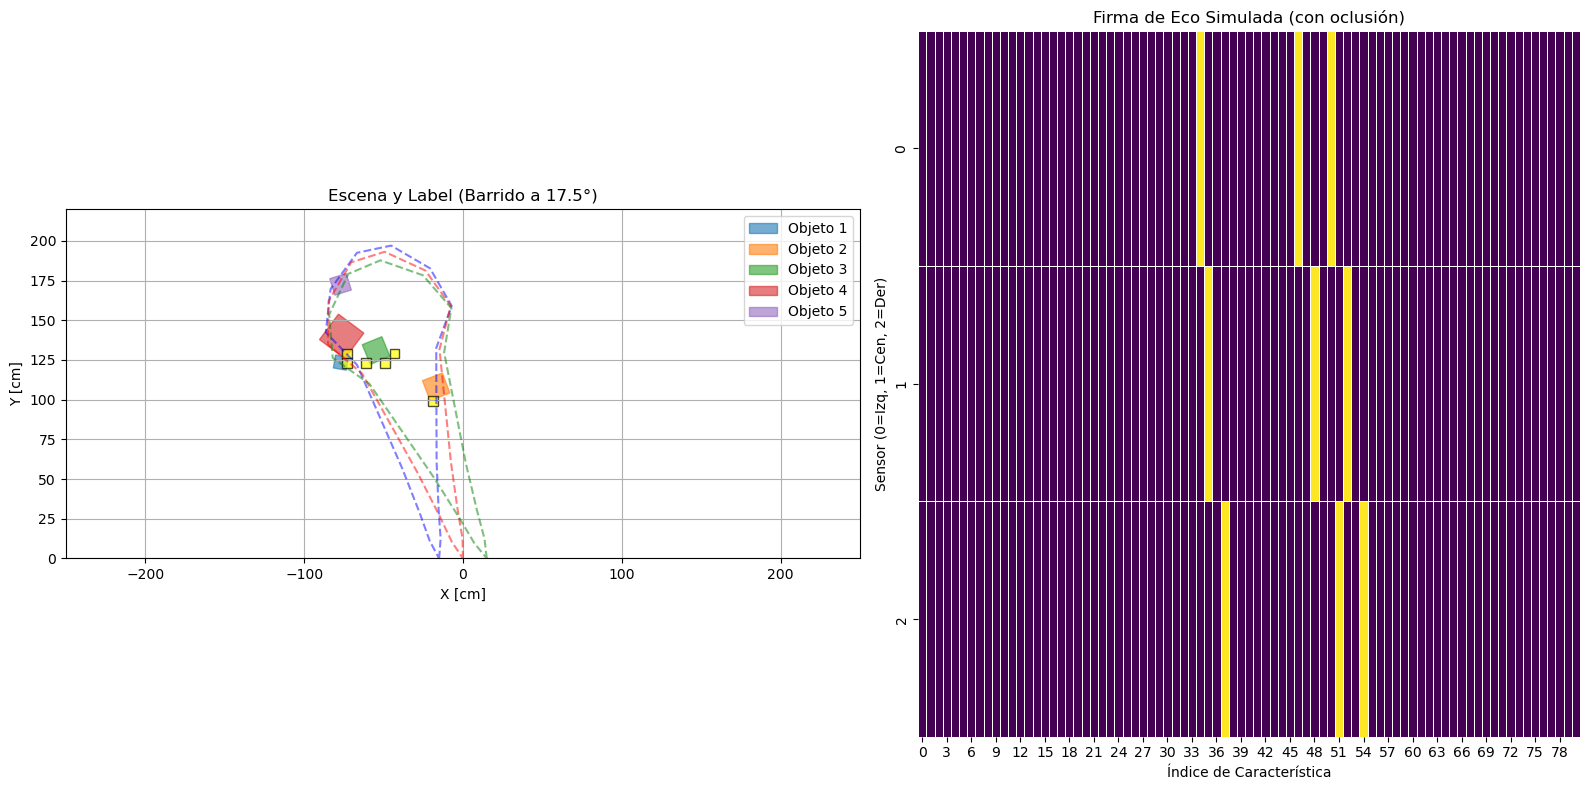

In [132]:
# ===================================================================
# Bloque de Validación y Visualización (para una muestra)
# ===================================================================
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1.2, 1]})

sample_number = 9

# Tomar la última muestra para validar
escena_muestra = escena_list[sample_number] # La última escena generada
angulo_muestra = angulo_central_list[sample_number]
haces_muestra = haces_list[sample_number]
label_muestra = labels_list[sample_number]
firma_eco_muestra = firma_eco_list[sample_number]

# --- Gráfico 1: Vista Espacial ---
colores_haces = ['blue', 'red', 'green']
for haz, color in zip(haces_muestra, colores_haces):
    ax1.plot(*haz.exterior.xy, color=color, linestyle='--', alpha=0.5)

for i, obj in enumerate(escena_muestra):
    ax1.fill(*obj.exterior.xy, color=f'C{i}', alpha=0.6, label=f'Objeto {i+1}')

cuadrantes_activos_indices = np.where(label_muestra == 1)[0]
print(cuadrantes_activos_indices)
for idx in cuadrantes_activos_indices:
    cuadrante = cuadrantes_globales[idx]
    ax1.fill(*cuadrante.exterior.xy, color='yellow', alpha=0.7, ec='black')

ax1.set_title(f"Escena y Label (Barrido a {angulo_muestra:.1f}°)")
ax1.set_xlabel("X [cm]"); ax1.set_ylabel("Y [cm]")
ax1.set_xlim(-250, 250); ax1.set_ylim(0, 220)
ax1.set_aspect('equal', adjustable='box'); ax1.grid(True); ax1.legend()

# --- Gráfico 2: Firma de Eco ---
firma_eco_matriz = firma_eco_muestra.reshape(3, 81)
sns.heatmap(firma_eco_matriz, ax=ax2, cbar=False, cmap="viridis", linewidths=.5)
ax2.set_title("Firma de Eco Simulada (con oclusión)")
ax2.set_xlabel("Índice de Característica"); ax2.set_ylabel("Sensor (0=Izq, 1=Cen, 2=Der)")

plt.tight_layout(); plt.show()

Modelo final, con las oclusiones mejor calculadas y testeadas. Es el modelo que vamos a utilizar al 16/11/25

In [128]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box, LineString
from shapely.ops import nearest_points, unary_union # <--- IMPORTADO unary_union
from shapely.affinity import rotate, translate
import random
import pandas as pd
from tqdm import tqdm

# ===================================================================
# FASE 1: Configuración y Parámetros
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 9
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0
MAX_OBJETOS_POR_ESCENA = 6
PROPORCIONES_OBJETOS = {'circulo': 0, 'rectangulo': 1, 'pared': 0}
RANGO_TAMAÑO_CIRCULO = [5.0, 12.0]; RANGO_TAMAÑO_RECTANGULO = [8.0, 20.0]; RANGO_TAMAÑO_PARED = [50.0, 100.0]
TAMAÑO_DEL_CUADRANTE = 6.0
VELOCIDAD_SONIDO = 34300; FRECUENCIA_MUESTREO_ADC = 140000; FRECUENCIA_MUESTREO_ML = 6800
NUM_MUESTRAS_TOTALES = 20

# ===================================================================
# FASE 2 y 3: Funciones Geométricas y de Generación de Escena
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad); py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d); angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d); angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def generar_haces_individuales(angulo_central):
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    haz_central = rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = translate(rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = translate(rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    return [haz_izq, haz_central, haz_der]

# ========= FUNCIÓN MODIFICADA =========
def generar_escena_aleatoria(area_de_generacion):
    escena = []; num_objetos = random.randint(1, MAX_OBJETOS_POR_ESCENA)
    # Ahora los límites se toman del área de los haces, que es más pequeña y específica
    min_x, min_y, max_x, max_y = area_de_generacion.bounds
    tipos = list(PROPORCIONES_OBJETOS.keys()); probabilidades = list(PROPORCIONES_OBJETOS.values())
    
    for _ in range(num_objetos):
        # Se intenta generar un objeto hasta 10 veces para asegurar que caiga dentro del área
        for i in range(10):
            px, py = random.uniform(min_x, max_x), random.uniform(min_y, max_y)
            
            # --> CAMBIO CLAVE: Se verifica que el punto esté DENTRO de la forma del haz
            if not area_de_generacion.contains(Point(px, py)):
                continue

            tipo_objeto = np.random.choice(tipos, p=probabilidades)
            objeto = None
            if tipo_objeto == 'circulo': objeto = Point(px, py).buffer(random.uniform(*RANGO_TAMAÑO_CIRCULO))
            elif tipo_objeto == 'rectangulo':
                lado = random.uniform(*RANGO_TAMAÑO_RECTANGULO)
                objeto = rotate(box(px - lado/2, py - lado/2, px + lado/2, py + lado/2), random.uniform(0, 360), origin='centroid')
            elif tipo_objeto == 'pared':
                longitud = random.uniform(*RANGO_TAMAÑO_PARED)
                objeto = rotate(LineString([(px - longitud/2, py), (px + longitud/2, py)]).buffer(2), random.uniform(0, 360), origin='centroid')
            
            if objeto and not any(obj_existente.contains(objeto.centroid) for obj_existente in escena): 
                escena.append(objeto)
                break # Si el objeto es válido y se añade, salimos del bucle de reintentos
    return escena

# ===================================================================
# FASE 4: Simulación de Ray-Tracing con Oclusión
# ===================================================================
def simular_reflexiones_con_oclusion(escena, haces_individuales):
    origenes = [Point(-DISTANCIA_ENTRE_SENSORES, 0), Point(0, 0), Point(DISTANCIA_ENTRE_SENSORES, 0)]
    ecos_por_sensor = []
    puntos_de_reflexion = [] 

    for haz, origen in zip(haces_individuales, origenes):
        objetos_en_haz = [obj for obj in escena if obj.intersects(haz)]
        if not objetos_en_haz:
            ecos_por_sensor.append([]); continue
        
        objetos_en_haz.sort(key=lambda obj: origen.distance(obj))
        ecos_sensor_actual = []
        area_ocluida = Polygon()
        
        for obj in objetos_en_haz:
            
            parte_en_haz = obj.intersection(haz)
            # Primero, vemos si la línea de visión directa al punto más cercano del objeto está bloqueada.
            _, punto_mas_cercano = nearest_points(origen, parte_en_haz)
            linea_de_vision = LineString([origen, punto_mas_cercano])
            linea_bloqueada = area_ocluida.intersects(linea_de_vision)
            # Luego, calculamos la parte visible restando los oclusores que se tocan directamente.
            parte_visible_real = parte_en_haz.difference(area_ocluida)
            
            if not linea_bloqueada and not parte_visible_real.is_empty:
                _, punto_eco_en_objeto = nearest_points(origen, parte_visible_real)
                distancia_eco = origen.distance(punto_eco_en_objeto)
                
                ecos_sensor_actual.append(distancia_eco)
                puntos_de_reflexion.append(punto_eco_en_objeto)
                
            area_ocluida = area_ocluida.union(obj)
        ecos_por_sensor.append(ecos_sensor_actual)
        
    return ecos_por_sensor, puntos_de_reflexion

# ===================================================================
# FASE 5: Generación del Dataset (Lógica Principal Actualizada)
# ===================================================================
def generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales):
    label = np.zeros(len(cuadrantes_globales))
    if not puntos_de_reflexion:
        return label

    cuadrantes_asignados = set()
    for punto in puntos_de_reflexion:
        for i, cuadrante in enumerate(cuadrantes_globales):
            if i not in cuadrantes_asignados and cuadrante.intersects(punto):
                label[i] = 1
                cuadrantes_asignados.add(i)
                break
    return label

def distancias_a_firma_eco(ecos_por_sensor):
    firma_eco_total = []; ratio_conversion = FRECUENCIA_MUESTREO_ML / FRECUENCIA_MUESTREO_ADC
    for distancias_cm in ecos_por_sensor:
        firma_sensor = np.zeros(81)
        for dist_cm in distancias_cm:
            tiempo_eco = (2 * dist_cm) / VELOCIDAD_SONIDO
            indice_adc = int(tiempo_eco * FRECUENCIA_MUESTREO_ADC)
            indice_ml = int((indice_adc - 100) * ratio_conversion)
            if 0 <= indice_ml < 81:
                firma_sensor[indice_ml] = 1
        firma_eco_total.extend(firma_sensor)
    return np.array(firma_eco_total)

def generar_una_muestra(cuadrantes_globales):
    while True:
            # Primero se define el ángulo y se generan los haces.
            angulo_central = random.choice(ANGULOS_DE_BARRIDO)
            haces = generar_haces_individuales(angulo_central)
            
            # --> CAMBIO DE LÓGICA 2: Se crea una geometría única que representa toda el área de los haces.
            area_de_haces = unary_union(haces)
            
            # --> CAMBIO DE LÓGICA 3: Se genera la escena DENTRO de esa área específica.
            escena = generar_escena_aleatoria(area_de_haces)
            if not escena: continue

            # 1. Simular ecos (Features) Y OBTENER LOS PUNTOS DE REFLEXIÓN
            ecos, puntos_de_reflexion = simular_reflexiones_con_oclusion(escena, haces)
            
            # Si no hay ecos, no es una muestra útil para el entrenamiento (en este nuevo enfoque).
            # Se podría cambiar si también se quieren muestras "vacías".
            if not puntos_de_reflexion:
                continue

            firma_eco = distancias_a_firma_eco(ecos)
            
            # 2. Generar la etiqueta (Label) BASADA EN LOS PUNTOS DE REFLEXIÓN
            label = generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales)
            
            # Solo se guardan muestras donde se detectó algo.
            if sum(firma_eco) > 0 and sum(label) > 0:
                feature = np.concatenate(([angulo_central], firma_eco))
                return (feature, label, escena, haces, angulo_central, firma_eco)

# --- Bucle Principal de Generación ---
if __name__ == "__main__":
    features_list, labels_list = [], []
    escena_list, haces_list, angulo_central_list, firma_eco_list = [],[],[],[]
    
    area_total_visible = box(-250, 0, 250, 220)
    x_coords = np.arange(area_total_visible.bounds[0], area_total_visible.bounds[2], TAMAÑO_DEL_CUADRANTE)
    y_coords = np.arange(area_total_visible.bounds[1], area_total_visible.bounds[3], TAMAÑO_DEL_CUADRANTE)
    cuadrantes_globales = [box(x, y, x + TAMAÑO_DEL_CUADRANTE, y + TAMAÑO_DEL_CUADRANTE) for x in x_coords for y in y_coords]

    num_cores = multiprocessing.cpu_count()
    print(f"Usando {num_cores} núcleos para generar {NUM_MUESTRAS_TOTALES} muestras con oclusión mejorada...")

    args_list = [cuadrantes_globales] * NUM_MUESTRAS_TOTALES
    
    with multiprocessing.Pool(num_cores) as pool:
        results = list(tqdm(pool.imap(generar_una_muestra, args_list), total=NUM_MUESTRAS_TOTALES))

    features_list, labels_list, escena_list, haces_list, angulo_central_list, firma_eco_list = zip(*results)
    print(f"\nGeneración completada: {len(features_list)} muestras consistentes creadas.")

    # --- Guardado ---
    df_features = pd.DataFrame(features_list)
    df_labels = pd.DataFrame(labels_list)
    df_features.to_csv("features_oclusion_mejorada.csv", index=False, header=False)
    df_labels.to_csv("labels_oclusion_mejorada.csv", index=False, header=False)
    print("Archivos CSV guardados.")

Usando 8 núcleos para generar 20 muestras con oclusión mejorada...


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 13.73it/s]


Generación completada: 20 muestras consistentes creadas.
Archivos CSV guardados.


## SANDBOX

In [86]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box, LineString
from shapely.ops import nearest_points
from shapely.affinity import rotate, translate
import random
import pandas as pd
from tqdm import tqdm

# ===================================================================
# FASE 1: Configuración y Parámetros
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 9
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0
MAX_OBJETOS_POR_ESCENA = 3
PROPORCIONES_OBJETOS = {'circulo': 0.0, 'rectangulo': 1, 'pared': 0.0}
RANGO_TAMAÑO_CIRCULO = [5.0, 12.0]; RANGO_TAMAÑO_RECTANGULO = [8.0, 20.0]; RANGO_TAMAÑO_PARED = [50.0, 100.0]
TAMAÑO_DEL_CUADRANTE = 6.0
VELOCIDAD_SONIDO = 34300; FRECUENCIA_MUESTREO_ADC = 140000; FRECUENCIA_MUESTREO_ML = 6800
NUM_MUESTRAS_TOTALES = 2

# ===================================================================
# FASE 2 y 3: Funciones Geométricas y de Generación de Escena
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad); py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d); angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d); angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def generar_haces_individuales(angulo_central):
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    haz_central = rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = translate(rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = translate(rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    return [haz_izq, haz_central, haz_der]

def generar_escena_aleatoria(area_total_visible):
    escena = []; num_objetos = random.randint(1, MAX_OBJETOS_POR_ESCENA)
    min_x, min_y, max_x, max_y = area_total_visible.bounds
    tipos = list(PROPORCIONES_OBJETOS.keys()); probabilidades = list(PROPORCIONES_OBJETOS.values())
    for _ in range(num_objetos):
        tipo_objeto = np.random.choice(tipos, p=probabilidades)
        px, py = random.uniform(min_x, max_x), random.uniform(min_y, max_y)
        objeto = None
        if tipo_objeto == 'circulo': objeto = Point(px, py).buffer(random.uniform(*RANGO_TAMAÑO_CIRCULO))
        elif tipo_objeto == 'rectangulo':
            lado = random.uniform(*RANGO_TAMAÑO_RECTANGULO)
            objeto = rotate(box(px - lado/2, py - lado/2, px + lado/2, py + lado/2), random.uniform(0, 360), origin='centroid')
        elif tipo_objeto == 'pared':
            longitud = random.uniform(*RANGO_TAMAÑO_PARED)
            objeto = rotate(LineString([(px - longitud/2, py), (px + longitud/2, py)]).buffer(2), random.uniform(0, 360), origin='centroid')
        if objeto and not any(obj_existente.contains(objeto.centroid) for obj_existente in escena): escena.append(objeto)
    return escena

# ===================================================================
# FASE 4: Simulación de Ray-Tracing con Oclusión
# ===================================================================
def simular_reflexiones_con_oclusion(escena, haces_individuales):
    origenes = [Point(-DISTANCIA_ENTRE_SENSORES, 0), Point(0, 0), Point(DISTANCIA_ENTRE_SENSORES, 0)]
    ecos_por_sensor = []
    puntos_de_reflexion = [] 

    for haz, origen in zip(haces_individuales, origenes):
        objetos_en_haz = [obj for obj in escena if obj.intersects(haz)]
        if not objetos_en_haz:
            ecos_por_sensor.append([]); continue
        
        objetos_en_haz.sort(key=lambda obj: origen.distance(obj))
        ecos_sensor_actual = []
        area_ocluida = Polygon()
        
        for obj in objetos_en_haz:
            parte_visible = (obj.intersection(haz)).difference(area_ocluida)
            if not parte_visible.is_empty:
                _, punto_eco_en_objeto = nearest_points(origen, parte_visible)
                distancia_eco = origen.distance(punto_eco_en_objeto)
                
                ecos_sensor_actual.append(distancia_eco)
                puntos_de_reflexion.append(punto_eco_en_objeto)
                
                area_ocluida = area_ocluida.union(obj)
        ecos_por_sensor.append(ecos_sensor_actual)
        
    return ecos_por_sensor, puntos_de_reflexion

# ===================================================================
# FASE 5: Generación del Dataset (Lógica Principal Actualizada)
# ===================================================================
def generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales):
    label = np.zeros(len(cuadrantes_globales))
    if not puntos_de_reflexion:
        return label

    cuadrantes_asignados = set()
    for punto in puntos_de_reflexion:
        for i, cuadrante in enumerate(cuadrantes_globales):
            if i not in cuadrantes_asignados and cuadrante.intersects(punto):
                label[i] = 1
                cuadrantes_asignados.add(i)
                break
    return label

def distancias_a_firma_eco(ecos_por_sensor):
    firma_eco_total = []; ratio_conversion = FRECUENCIA_MUESTREO_ML / FRECUENCIA_MUESTREO_ADC
    for distancias_cm in ecos_por_sensor:
        firma_sensor = np.zeros(81)
        for dist_cm in distancias_cm:
            tiempo_eco = (2 * dist_cm) / VELOCIDAD_SONIDO
            indice_adc = int(tiempo_eco * FRECUENCIA_MUESTREO_ADC)
            indice_ml = int((indice_adc - 100) * ratio_conversion)
            if 0 <= indice_ml < 81:
                firma_sensor[indice_ml] = 1
        firma_eco_total.extend(firma_sensor)
    return np.array(firma_eco_total)

# --- Bucle Principal de Generación ---
if __name__ == "__main__":
    features_list, labels_list = [], []
    escena_list, haces_list, angulo_central_list, firma_eco_list = [],[],[],[]
    
    area_total_visible = box(-250, 0, 250, 220)
    x_coords = np.arange(area_total_visible.bounds[0], area_total_visible.bounds[2], TAMAÑO_DEL_CUADRANTE)
    y_coords = np.arange(area_total_visible.bounds[1], area_total_visible.bounds[3], TAMAÑO_DEL_CUADRANTE)
    cuadrantes_globales = [box(x, y, x + TAMAÑO_DEL_CUADRANTE, y + TAMAÑO_DEL_CUADRANTE) for x in x_coords for y in y_coords]

    print(f"Generando {NUM_MUESTRAS_TOTALES} muestras para el dataset...")
    
    with tqdm(total=NUM_MUESTRAS_TOTALES) as pbar:
        while len(features_list) < NUM_MUESTRAS_TOTALES:
            
            escena = generar_escena_aleatoria(area_total_visible)
            if not escena: continue
            
            angulo_central = random.choice(ANGULOS_DE_BARRIDO)
            haces = generar_haces_individuales(angulo_central)
            
            # 1. Simular ecos (Features) Y OBTENER LOS PUNTOS DE REFLEXIÓN
            ecos, puntos_de_reflexion = simular_reflexiones_con_oclusion(escena, haces)
            firma_eco = distancias_a_firma_eco(ecos)
            
            # 2. Generar la etiqueta (Label) BASADA EN LOS PUNTOS DE REFLEXIÓN
            label = generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales)
            
            # Ahora las features y labels son consistentes por diseño.
            # Tanto las muestras positivas (con eco y label) como las negativas 
            # (sin eco y sin label) son valiosas y se guardan.
            if sum(firma_eco) > 0:
                feature = np.concatenate(([angulo_central], firma_eco))
                features_list.append(feature)
                labels_list.append(label)
    
                escena_list.append(escena)
                haces_list.append(haces)
                angulo_central_list.append(angulo_central)
                firma_eco_list.append(firma_eco)
                firma_eco = 0.0
                pbar.update(1)

    print(f"\nGeneración completada: {len(features_list)} muestras consistentes creadas.")

    # --- Guardado ---
    df_features = pd.DataFrame(features_list)
    df_labels = pd.DataFrame(labels_list)
    df_features.to_csv("features_multiobjeto_consistente.csv", index=False, header=False)
    df_labels.to_csv("labels_multiobjeto_consistente.csv", index=False, header=False)
    print("Archivos CSV guardados.")

Generando 2 muestras para el dataset...


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 22.12it/s]


Generación completada: 2 muestras consistentes creadas.
Archivos CSV guardados.


In [115]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, box, LineString
from shapely.ops import nearest_points, unary_union # <--- IMPORTADO unary_union
from shapely.affinity import rotate, translate
import random
import pandas as pd
from tqdm import tqdm

# ===================================================================
# FASE 1: Configuración y Parámetros
# ===================================================================
DISTANCIA_ENTRE_SENSORES = 15
DISTANCIA_DE_ENFOQUE = 150
RANGO_DE_ANGULO = 140.0
NUMERO_DE_PASOS = 9
ANGULOS_DE_BARRIDO = np.linspace(-RANGO_DE_ANGULO / 2, RANGO_DE_ANGULO / 2, NUMERO_DE_PASOS)
SINGLE_BEAM_SHAPE_POINTS = [
    (0.00, 0.00), (0.035, 0.12), (0.06, 0.3), (0.11, 0.6), (0.255, 1.3),
    (0.405, 1.54), (0.32, 1.8), (0.11, 1.99), (-0.11, 1.99), (-0.32, 1.8),
    (-0.405, 1.54), (-0.255, 1.3), (-0.11, 0.6), (-0.06, 0.3), (-0.035, 0.12),
    (0.00, 0.00)
]
FACTOR_ESCALA_HAZ = 100.0
MAX_OBJETOS_POR_ESCENA = 6
PROPORCIONES_OBJETOS = {'circulo': 0, 'rectangulo': 1, 'pared': 0}
RANGO_TAMAÑO_CIRCULO = [5.0, 12.0]; RANGO_TAMAÑO_RECTANGULO = [8.0, 20.0]; RANGO_TAMAÑO_PARED = [50.0, 100.0]
TAMAÑO_DEL_CUADRANTE = 6.0
VELOCIDAD_SONIDO = 34300; FRECUENCIA_MUESTREO_ADC = 140000; FRECUENCIA_MUESTREO_ML = 6800
NUM_MUESTRAS_TOTALES = 20

# ===================================================================
# FASE 2 y 3: Funciones Geométricas y de Generación de Escena
# ===================================================================
def obtener_angulos_optimos(theta_central_deg, d, R):
    theta_central_math_rad = np.deg2rad(theta_central_deg + 90)
    px = R * np.cos(theta_central_math_rad); py = R * np.sin(theta_central_math_rad)
    angulo_math_izq = np.arctan2(py, px + d); angulo_final_izq = np.rad2deg(angulo_math_izq) - 90
    angulo_math_der = np.arctan2(py, px - d); angulo_final_der = np.rad2deg(angulo_math_der) - 90
    return angulo_final_izq, angulo_final_der

def crear_haz_desde_puntos(shape_points, scale_factor):
    scaled_points = [(x * scale_factor, y * scale_factor) for x, y in shape_points]
    return Polygon(scaled_points)

def generar_haces_individuales(angulo_central):
    angulo_izq, angulo_der = obtener_angulos_optimos(angulo_central, DISTANCIA_ENTRE_SENSORES, DISTANCIA_DE_ENFOQUE)
    haz_base = crear_haz_desde_puntos(SINGLE_BEAM_SHAPE_POINTS, FACTOR_ESCALA_HAZ)
    haz_central = rotate(haz_base, angulo_central, origin=(0, 0))
    haz_izq = translate(rotate(haz_base, angulo_izq, origin=(0, 0)), xoff=-DISTANCIA_ENTRE_SENSORES)
    haz_der = translate(rotate(haz_base, angulo_der, origin=(0, 0)), xoff=DISTANCIA_ENTRE_SENSORES)
    return [haz_izq, haz_central, haz_der]

# ========= FUNCIÓN MODIFICADA =========
def generar_escena_aleatoria(area_de_generacion):
    escena = []; num_objetos = random.randint(1, MAX_OBJETOS_POR_ESCENA)
    # Ahora los límites se toman del área de los haces, que es más pequeña y específica
    min_x, min_y, max_x, max_y = area_de_generacion.bounds
    tipos = list(PROPORCIONES_OBJETOS.keys()); probabilidades = list(PROPORCIONES_OBJETOS.values())
    
    for _ in range(num_objetos):
        # Se intenta generar un objeto hasta 10 veces para asegurar que caiga dentro del área
        for i in range(10):
            px, py = random.uniform(min_x, max_x), random.uniform(min_y, max_y)
            
            # --> CAMBIO CLAVE: Se verifica que el punto esté DENTRO de la forma del haz
            if not area_de_generacion.contains(Point(px, py)):
                continue

            tipo_objeto = np.random.choice(tipos, p=probabilidades)
            objeto = None
            if tipo_objeto == 'circulo': objeto = Point(px, py).buffer(random.uniform(*RANGO_TAMAÑO_CIRCULO))
            elif tipo_objeto == 'rectangulo':
                lado = random.uniform(*RANGO_TAMAÑO_RECTANGULO)
                objeto = rotate(box(px - lado/2, py - lado/2, px + lado/2, py + lado/2), random.uniform(0, 360), origin='centroid')
            elif tipo_objeto == 'pared':
                longitud = random.uniform(*RANGO_TAMAÑO_PARED)
                objeto = rotate(LineString([(px - longitud/2, py), (px + longitud/2, py)]).buffer(2), random.uniform(0, 360), origin='centroid')
            
            if objeto and not any(obj_existente.contains(objeto.centroid) for obj_existente in escena): 
                escena.append(objeto)
                break # Si el objeto es válido y se añade, salimos del bucle de reintentos
    return escena

# ===================================================================
# FASE 4: Simulación de Ray-Tracing con Oclusión
# ===================================================================
def simular_reflexiones_con_oclusion(escena, haces_individuales):
    origenes = [Point(-DISTANCIA_ENTRE_SENSORES, 0), Point(0, 0), Point(DISTANCIA_ENTRE_SENSORES, 0)]
    ecos_por_sensor = []
    puntos_de_reflexion = [] 

    for haz, origen in zip(haces_individuales, origenes):
        objetos_en_haz = [obj for obj in escena if obj.intersects(haz)]
        if not objetos_en_haz:
            ecos_por_sensor.append([]); continue
        
        objetos_en_haz.sort(key=lambda obj: origen.distance(obj))
        ecos_sensor_actual = []
        area_ocluida = Polygon()
        
        for obj in objetos_en_haz:
            
            parte_en_haz = obj.intersection(haz)
            # Primero, vemos si la línea de visión directa al punto más cercano del objeto está bloqueada.
            _, punto_mas_cercano = nearest_points(origen, parte_en_haz)
            linea_de_vision = LineString([origen, punto_mas_cercano])
            linea_bloqueada = area_ocluida.intersects(linea_de_vision)
            # Luego, calculamos la parte visible restando los oclusores que se tocan directamente.
            parte_visible_real = parte_en_haz.difference(area_ocluida)
            
            if not linea_bloqueada and not parte_visible_real.is_empty:
                _, punto_eco_en_objeto = nearest_points(origen, parte_visible_real)
                distancia_eco = origen.distance(punto_eco_en_objeto)
                
                ecos_sensor_actual.append(distancia_eco)
                puntos_de_reflexion.append(punto_eco_en_objeto)
                
            area_ocluida = area_ocluida.union(obj)
        ecos_por_sensor.append(ecos_sensor_actual)
        
    return ecos_por_sensor, puntos_de_reflexion

# ===================================================================
# FASE 5: Generación del Dataset (Lógica Principal Actualizada)
# ===================================================================
def generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales):
    label = np.zeros(len(cuadrantes_globales))
    if not puntos_de_reflexion:
        return label

    cuadrantes_asignados = set()
    for punto in puntos_de_reflexion:
        for i, cuadrante in enumerate(cuadrantes_globales):
            if i not in cuadrantes_asignados and cuadrante.intersects(punto):
                label[i] = 1
                cuadrantes_asignados.add(i)
                break
    return label

def distancias_a_firma_eco(ecos_por_sensor):
    firma_eco_total = []; ratio_conversion = FRECUENCIA_MUESTREO_ML / FRECUENCIA_MUESTREO_ADC
    for distancias_cm in ecos_por_sensor:
        firma_sensor = np.zeros(81)
        for dist_cm in distancias_cm:
            tiempo_eco = (2 * dist_cm) / VELOCIDAD_SONIDO
            indice_adc = int(tiempo_eco * FRECUENCIA_MUESTREO_ADC)
            indice_ml = int((indice_adc - 100) * ratio_conversion)
            if 0 <= indice_ml < 81:
                firma_sensor[indice_ml] = 1
        firma_eco_total.extend(firma_sensor)
    return np.array(firma_eco_total)

# --- Bucle Principal de Generación ---
if __name__ == "__main__":
    features_list, labels_list = [], []
    escena_list, haces_list, angulo_central_list, firma_eco_list = [],[],[],[]
    
    area_total_visible = box(-250, 0, 250, 220)
    x_coords = np.arange(area_total_visible.bounds[0], area_total_visible.bounds[2], TAMAÑO_DEL_CUADRANTE)
    y_coords = np.arange(area_total_visible.bounds[1], area_total_visible.bounds[3], TAMAÑO_DEL_CUADRANTE)
    cuadrantes_globales = [box(x, y, x + TAMAÑO_DEL_CUADRANTE, y + TAMAÑO_DEL_CUADRANTE) for x in x_coords for y in y_coords]

    print(f"Generando {NUM_MUESTRAS_TOTALES} muestras para el dataset...")
    
    with tqdm(total=NUM_MUESTRAS_TOTALES) as pbar:
        while len(features_list) < NUM_MUESTRAS_TOTALES:
            
            # --> CAMBIO DE LÓGICA 1: Primero se define el ángulo y se generan los haces.
            angulo_central = random.choice(ANGULOS_DE_BARRIDO)
            haces = generar_haces_individuales(angulo_central)
            
            # --> CAMBIO DE LÓGICA 2: Se crea una geometría única que representa toda el área de los haces.
            area_de_haces = unary_union(haces)
            
            # --> CAMBIO DE LÓGICA 3: Se genera la escena DENTRO de esa área específica.
            escena = generar_escena_aleatoria(area_de_haces)
            if not escena: continue

            # 1. Simular ecos (Features) Y OBTENER LOS PUNTOS DE REFLEXIÓN
            ecos, puntos_de_reflexion = simular_reflexiones_con_oclusion(escena, haces)
            
            # Si no hay ecos, no es una muestra útil para el entrenamiento (en este nuevo enfoque).
            # Se podría cambiar si también se quieren muestras "vacías".
            if not puntos_de_reflexion:
                continue

            firma_eco = distancias_a_firma_eco(ecos)
            
            # 2. Generar la etiqueta (Label) BASADA EN LOS PUNTOS DE REFLEXIÓN
            label = generar_label_desde_detecciones(puntos_de_reflexion, cuadrantes_globales)
            
            # Solo se guardan muestras donde se detectó algo.
            if sum(firma_eco) > 0 and sum(label) > 0:
                feature = np.concatenate(([angulo_central], firma_eco))
                features_list.append(feature)
                labels_list.append(label)
    
                escena_list.append(escena)
                haces_list.append(haces)
                angulo_central_list.append(angulo_central)
                firma_eco_list.append(firma_eco)
                
                pbar.update(1)

    print(f"\nGeneración completada: {len(features_list)} muestras consistentes creadas.")

    # --- Guardado ---
    df_features = pd.DataFrame(features_list)
    df_labels = pd.DataFrame(labels_list)
    df_features.to_csv("features_multiobjeto_consistente_en_haz.csv", index=False, header=False)
    df_labels.to_csv("labels_multiobjeto_consistente_en_haz.csv", index=False, header=False)
    print("Archivos CSV guardados.")

Generando 20 muestras para el dataset...


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 11.06it/s]



Generación completada: 20 muestras consistentes creadas.
Archivos CSV guardados.
